In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import tqdm
import multiprocessing as mproc

import seaborn as sns

import util
import dtaidistance.dtw
from dtaidistance import dtw_visualisation as dtwvis

experiments = [{'dist_type': 'fit','n_bins': 3000, 'predefined_dists': True},
               {'dist_type': 'empirical','n_bins': 3000, 'predefined_dists': True}
              ]

In [2]:
input_data_params = []
for i in range(5):
    # if i != 1:
    #     continue
    input_data_params.append(
        {   'file_column': 'Logits_Negative',
            'days_range': (i*7+1,(i+1)*7+1 if i < 4 else 32), 
            'months_range': (7,8), 
            'hours_range': (0,24), 
            'sampling_p': 0.1
        }
    )

In [3]:
def process_sample_input(input):
    results = {}
    stream_ln, tweets_per_file = util.load_data(**input)
    if len(tweets_per_file) == 0:
        return

    for e in experiments:
        d_type = e['dist_type']
        args = (e['n_bins'], tweets_per_file, d_type, e['predefined_dists'])
        results[d_type] = util.run(args)
        
    filename = f'../results/detect_drifts_m_{input["months_range"][0]}_' \
                + f'{input["months_range"][1]}_' \
                + f'd_{input["days_range"][0]}_' \
                + f'{input["days_range"][1]}' \
                + f'_{int(time.time())}.pkl'
    pd.to_pickle(results, filename)
    print(filename)


In [ ]:
args_gen = (input for input in input_data_params)
results = mproc.Pool(processes=5).imap(process_sample_input, args_gen)
tqdm.tqdm(total=len(input_data_params))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 168/168 [21:01<00:00,  7.51s/it]


Number of tweets processed:  2286745


100%|██████████| 168/168 [22:10<00:00,  7.92s/it]


Number of tweets processed:  2507278


100%|██████████| 168/168 [24:20<00:00,  8.69s/it]


Number of tweets processed:  2528323


100%|██████████| 168/168 [1:56:34<00:00, 41.63s/it]  


Number of tweets processed:  2507278
../results/detect_drifts_m_7_8_d_1_8_1683069577.pkl


100%|██████████| 168/168 [2:08:15<00:00, 45.81s/it]


Number of tweets processed:  2286745
../results/detect_drifts_m_7_8_d_22_29_1683070216.pkl


100%|██████████| 168/168 [2:14:09<00:00, 47.92s/it]


Number of tweets processed:  2528323
../results/detect_drifts_m_7_8_d_15_22_1683070770.pkl


In [6]:
!shutdown -c

In [13]:
results = pd.read_pickle('../results/detect_drifts_m_3_4_d_22_29_1682969893.pkl')

results_times = {}
results_drifts = {}
dtw_dist_vs_minibatch = {}
dtw_fit_vs_empirical = {}

for exp_type in results:
    results_drifts[exp_type] = results[exp_type][0]
    results_times[exp_type] = results[exp_type][1]

    dtw_dist_vs_minibatch[exp_type] = {k:dtaidistance.dtw.distance(results_drifts[exp_type].get(k, []), results_drifts[exp_type]['mini-batch'])
                                       for k in util.approx_methods}


dtw_fit_vs_empirical = {'DTW - Fit vs Empirical':
                          {k:dtaidistance.dtw.distance(results_drifts['fit'].get(k, []), results_drifts['empirical'].get(k, []))
                                for k in results_drifts['fit'].keys()},
                        'qtd drifts Fit':
                          {k:len(results_drifts['fit'][k]) for k in results_drifts['fit'].keys()},
                        'qtd drifts Empirical':
                          {k:len(results_drifts['empirical'][k]) for k in results_drifts['fit'].keys()}
                        }


In [14]:
display(pd.DataFrame(results_times))

display(pd.DataFrame(dtw_fit_vs_empirical))

display(pd.DataFrame(dtw_dist_vs_minibatch))

,fit,empirical
Page Hinkley,0.937458,1.878524
GreedyKS,103.354410,1426.988446
Reservoir Sampling,385.666886,3483.142218
IKS + RS,108.324116,94.686866


,DTW - Fit vs Empirical,qtd drifts Fit,qtd drifts Empirical
Page Hinkley,0.000000e+00,134,134
GreedyKS,5.333051e+04,163,90
Reservoir Sampling,1.293953e+06,115,25
IKS + RS,2.086630e+05,51,23
mini-batch,5.687234e+04,162,83


,fit,empirical
Page Hinkley,41299.259812,5.634799e+04
GreedyKS,12298.720543,3.749129e+04
Reservoir Sampling,133906.910673,9.772833e+05
IKS + RS,994545.759848,1.137344e+06


GreedyKS
Reservoir Sampling
IKS + RS
mini-batch


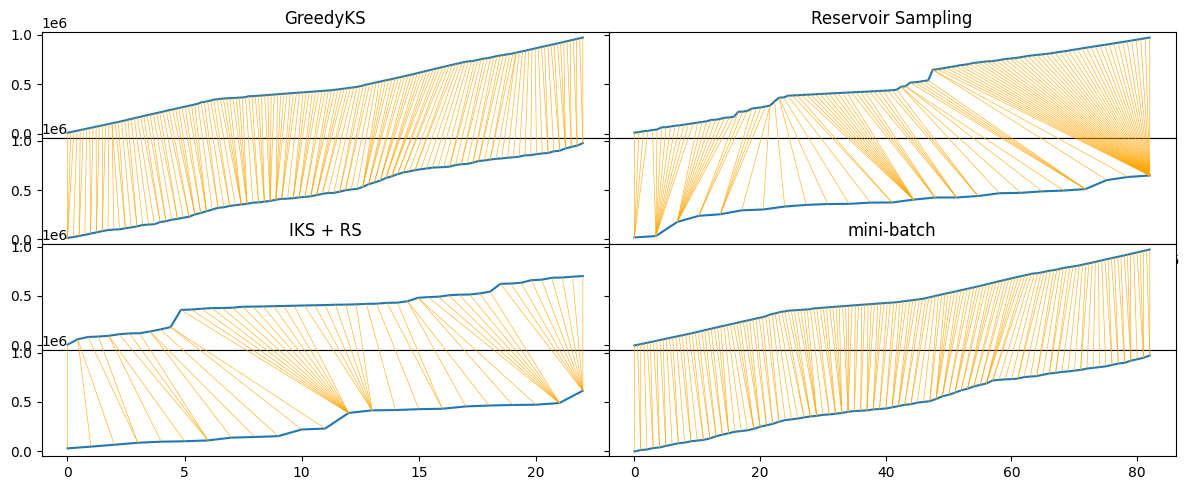

In [15]:
f_vs_e = [(results_drifts['fit'].get(k, []), results_drifts['empirical'].get(k, [])) for k in results_drifts['fit'].keys() if k != 'Page Hinkley']

figg, axs = plt.subplots(4, 2, figsize=(12,5), sharey=True, gridspec_kw={'hspace':0.0, 'wspace':0.0})

for i,k in enumerate(results_drifts['fit'].keys()):
    if k == 'Page Hinkley':
        continue
    s1 = np.array(results_drifts['fit'].get(k, []))
    s2 = np.array(results_drifts['empirical'].get(k, []))

    print(k)
    if i == 3 or i == 4:
        init = 2
    else:
        init = 0

    if i == 1:
        axs[0][0].set_title(k)
    elif i == 2:
        axs[0][1].set_title(k)
    elif i == 3:
        axs[2][0].set_title(k)
    elif i == 4:
        axs[2][1].set_title(k)

    path = dtaidistance.dtw.warping_path(s1, s2)
    dtwvis.plot_warping(s1, s2, path, fig=figg, axs=axs.T[(i-1)%2][init:])

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U18'), dtype('<U18')) -> None

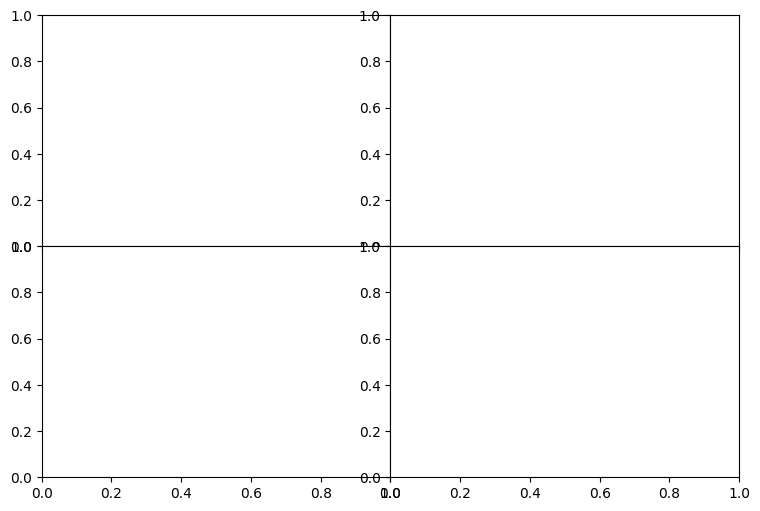

In [23]:
axes_prop_cycle = {
    'markersize':[8]*20,
    'linewidth':[1]*20,
    'markevery': [8]*20,
    'marker':['o', 'X', 's', 'P', 'D']*4,
    'color':sns.color_palette("Set1", 20)
}

def show_results(results, axs, d_type, legend=False):
    bps = axs[0].boxplot(results, vert=False, patch_artist=True)
    axs[0].set_xscale('log')
    axs[0].grid(axis='x')
    axs[0].set_title(r'Distribution type: ' + d_type)
    axs[0].set_yticklabels([])
    
    for i, j, k, l in zip(bps['boxes'], bps['medians'], axes_prop_cycle['marker'][3::-1], axes_prop_cycle['color']):
        i.set_facecolor(l)
        j.set_color('black')
        j.set_marker(k)
        j.set_markevery(1)
        j.set_markerfacecolor(l)
    
    sns.ecdfplot(results, log_scale=True, ax=axs[1], legend=legend, alpha=0.8)
    axs[1].grid()
    axs[1].set_ylim([-0.05, 1.05])
    
    return bps

fig, axs = plt.subplots(2,2, sharex=True, figsize=(9,6), gridspec_kw={'hspace':0.0, 'wspace':0.0})

for e, (i,j) in enumerate(zip(results_dtw, axs.T)):
    zz = show_results(results_dtw[i], j, i, e == 1)
    j[0].set_yticklabels([])
    
    if e:
        j[1].set_yticklabels([])
        j[1].set_ylabel('')
    

axs[1,0].set_ylabel('Cumulative Probability')
axs[1,1].set_xlabel('DTW value')
sns.move_legend(axs[1,1], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.45))

for i, j in zip(axs[1,1].legend_.legendHandles, axes_prop_cycle['marker'][3::-1]): 
    i.set_marker(j)
    i.set_markersize(8)


fig.tight_layout()

# fig.savefig('./data_pdf_files/call_center.pdf')

In [2]:
# methods_colors = {
#     "Reservoir Sampling" : 'r',
#     "GreedyKS" : 'g',
#     "IKS + RS" : 'b',
#     'Page Hinkley': 'yellow'

# }

def show_stats(methods_drifts, methods_times):
    n_drifts = [len(methods_drifts[m]) for m in methods_drifts]
    df = pd.DataFrame([methods_times.values(),n_drifts], index=['time', 'drifts'], columns=methods_times.keys())
    display(df)

In [4]:
for r in results:
    print(r)
    show_stats(*results[r])

fit


,Page Hinkley,GreedyKS,Reservoir Sampling,IKS + RS
time,0.036164,0.716456,0.743053,0.638199
drifts,11.000000,19.000000,19.000000,18.000000


empirical


,Page Hinkley,GreedyKS,Reservoir Sampling,IKS + RS
time,0.035441,1.071255,3.329258,2.440134
drifts,11.000000,20.000000,20.000000,19.000000


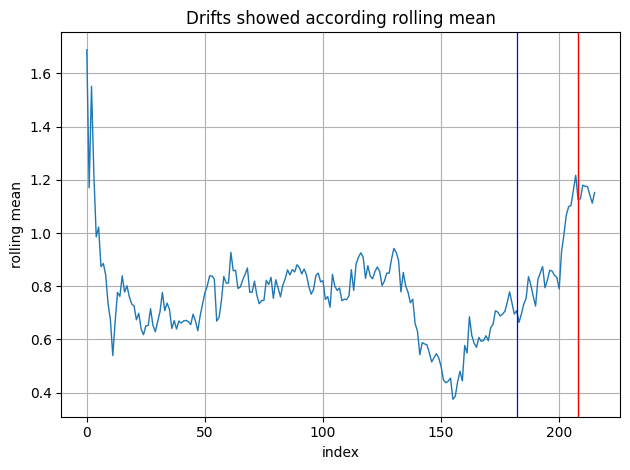

In [ ]:
files = get_file_names()
stream = []
for file in files:
    stream.append(pd.read_csv(file)['Logits_Negative'])
stream = pd.concat(stream, ignore_index=True)


rolling_mean = stream.rolling(len(stream)//10, min_periods=0).mean()

# plt.figure(figsize=(5,3.5))
plt.plot(rolling_mean, linewidth=1)

for m in methods_drifts:
    # if m != 'page hinkley':
    #     continue
    for d in methods_drifts[m]:
        plt.axvline(x = d, color = methods_colors[m], linewidth=0.9, label=m)




plt.title('Drifts showed according rolling mean')
# plt.legend()
plt.xlabel('index')
plt.ylabel('rolling mean')
plt.grid(True)
plt.tight_layout()
plt.show()